<a href="https://colab.research.google.com/github/snehasrini99/Network_attack_classification/blob/main/evaluation_cv_kdd_all.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 10-fold Cross Validation
10-fold Cross validation code using kdd dataset
: double checks if it is not overfitting for Random Forest and KNN models

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import statsmodels.api as sm
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree  import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn import svm
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import RocCurveDisplay #changed From sklearn 1.2
from sklearn.model_selection import GridSearchCV
from mlxtend.plotting import plot_confusion_matrix

# Turn off the warnings.
warnings.filterwarnings(action='ignore')
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%cd drive/MyDrive/24Spring/NSP/Project

/content/drive/MyDrive/24Spring/NSP/Project


### CROSS VALIDATION def

In [4]:
from tqdm.notebook import tqdm
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def cv1(X,y, clf):
  cv_outcome = cross_validate(clf, X,y, scoring=('accuracy','precision','recall','f1','roc_auc'), return_train_score=True, cv=10)
  print_outcome1(cv_outcome)

#outcome def
def print_outcome1(result):

  mean_test_accuracy = np.mean(result["test_accuracy"])
  mean_train_accuracy = np.mean(result["train_accuracy"])
  mean_test_precision = np.mean(result["test_precision"])
  mean_train_precision = np.mean(result["train_precision"])
  mean_test_recall = np.mean(result["test_recall"])
  mean_train_recall = np.mean(result["train_recall"])
  mean_test_f1 = np.mean(result["test_f1"])
  mean_train_f1 = np.mean(result["train_f1"])
  mean_test_auc = np.mean(result["test_roc_auc"])
  mean_train_auc = np.mean(result["train_roc_auc"])

  outcome_dict = {
      "Metric" : ["accuracy", "precision", "recall", "f1", "auc"],
      "Mean Train Score" : [mean_train_accuracy, mean_train_precision, mean_train_recall, mean_train_f1, mean_train_auc],
      "Mean Test Score" : [mean_test_accuracy, mean_test_precision, mean_test_recall, mean_test_f1, mean_test_auc]

  }

  outcome_df = pd.DataFrame(outcome_dict)
  print(outcome_df)

  plt.figure(figsize=(10, 6))
  plt.bar(outcome_df['Metric'], outcome_df['Mean Train Score'], width=0.4, label='Train Score', align='center') #training
  plt.bar(outcome_df['Metric'], outcome_df['Mean Test Score'], width=0.4, label='Test Score', align='edge') #testing
  plt.xlabel('Metrics')
  plt.ylabel('Scores')
  plt.legend()
  plt.show()

In [5]:
def GridSearch(Model_Abb, Parameters, X_train, Y_train):
    Grid = GridSearchCV(estimator=Model_Abb, param_grid= Parameters, cv = 3, n_jobs=-1)
    Grid_Result = Grid.fit(X_train, Y_train)
    Model_Name = Grid_Result.best_estimator_

    return (Model_Name)

## Cleaned KDD Data

In [6]:
Trained_Data = pd.read_csv("/content/drive/MyDrive/24Spring/NSP/Project/Data_final/Cleaned_Trained_Data.csv" , sep = "," , encoding = 'utf-8')
Tested_Data  = pd.read_csv("/content/drive/MyDrive/24Spring/NSP/Project/Data_final/Cleaned_Tested_Data.csv" , sep = "," , encoding = 'utf-8')

In [7]:
# Trained_Data.info()

In [8]:
# Tested_Data.info()

### Data Encoding

In [9]:
Trained_Data = pd.get_dummies(Trained_Data,columns=['protocol_type','service','flag'],prefix="",prefix_sep="")
Tested_Data = pd.get_dummies(Tested_Data,columns=['protocol_type','service','flag'],prefix="",prefix_sep="")

In [10]:
LE = LabelEncoder()
attack_LE= LabelEncoder()
Trained_Data['attack'] = attack_LE.fit_transform(Trained_Data["attack"])
Tested_Data['attack'] = attack_LE.fit_transform(Tested_Data["attack"])

### Data Splitting

In [11]:
X_train = Trained_Data.drop(['attack', 'level', 'attack_state'], axis=1)
X_test = Tested_Data.drop(['attack', 'level', 'attack_state'], axis=1)


Y_train = Trained_Data['attack_state']
Y_test = Tested_Data['attack_state']

X_train_train,X_test_train ,Y_train_train,Y_test_train = train_test_split(X_train, Y_train, test_size= 0.25 , random_state=42)
X_train_test,X_test_test,Y_train_test,Y_test_test = train_test_split(X_test, Y_test, test_size= 0.25 , random_state=42)

### Data Scaling

In [12]:
Ro_scaler = RobustScaler()
X_train_train = Ro_scaler.fit_transform(X_train_train)
X_test_train = Ro_scaler.transform(X_test_train)
X_train_test = Ro_scaler.fit_transform(X_train_test)
X_test_test = Ro_scaler.transform(X_test_test)

In [13]:
X_train_train.shape, Y_train_train.shape
X_test_train.shape, Y_test_train.shape
X_train_test.shape, Y_train_test.shape
X_test_test.shape, Y_test_test.shape

((5636, 116), (5636,))

### VIF

In [14]:
A = sm.add_constant(X_train.astype(float))
Est1 = sm.GLM(Y_train, A)
Est2 = Est1.fit()
Est2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           attack_state   No. Observations:               125972
Model:                            GLM   Df Residuals:                   125854
Model Family:                Gaussian   Df Model:                          117
Link Function:               Identity   Scale:                        0.030165
Method:                          IRLS   Log-Likelihood:                 41832.
Date:                Tue, 07 May 2024   Deviance:                       3796.3
Time:                        00:46:53   Pearson chi2:                 3.80e+03
No. Iterations:                     3   Pseudo R-squ. (CS):             0.9993
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                           0.3035      0.008     40.015      0.000       0.289       0.318
duration                    -4.074e-06   2.35e-07    -17.350      0.000   -4.53e-06   -3.61e-06
src_bytes                    4.584e-10   8.53e-11      5.373      0.000    2.91e-10    6.26e-10
dst_bytes                     1.67e-10   1.22e-10      1.372      0.170   -7.17e-11    4.06e-10
land                           -0.2506      0.035     -7.079      0.000      -0.320      -0.181
wrong_fragment                  0.1968      0.002     86.967      0.000       0.192       0.201
urgent                         -0.0057      0.035     -0.165      0.869      -0.073       0.062
hot                             0.0251      0.000     55.886      0.000       0.024       0.026
num_failed_logins               0.0499      0.011      4.470      0.000       0.028       0.072
logged_in                       0.1670      0.004     42.903      0.000       0.159       0.175
num_compromised                 0.0086      0.001     13.969      0.000       0.007       0.010
root_shell                      0.1463      0.017      8.532      0.000       0.113       0.180
su_attempted                   -0.0668      0.018     -3.779      0.000      -0.101      -0.032
num_root                       -0.0086      0.001    -13.991      0.000      -0.010      -0.007
num_file_creations             -0.0121      0.001    -11.550      0.000      -0.014      -0.010
num_shells                     -0.0192      0.022     -0.858      0.391      -0.063       0.025
num_access_files                0.0338      0.007      4.991      0.000       0.021       0.047
num_outbound_cmds            6.425e-16   6.05e-16      1.062      0.288   -5.44e-16    1.83e-15
is_host_login                  -0.3679      0.174     -2.117      0.034      -0.708      -0.027
is_guest_login                 -0.4361      0.013    -34.383      0.000      -0.461      -0.411
count                           0.0002   1.03e-05     15.557      0.000       0.000       0.000
srv_count                       0.0004   1.53e-05     24.095      0.000       0.000       0.000
serror_rate                    -0.0656      0.012     -5.335      0.000      -0.090      -0.042
srv_serror_rate                 0.2685      0.013     20.041      0.000       0.242       0.295
rerror_rate                    -0.0820      0.013     -6.233      0.000      -0.108      -0.056
srv_rerror_rate                 0.6245      0.015     40.926      0.000       0.595       0.654
same_srv_rate                  -0.3404      0.004    -78.481      0.000      -0.349      -0.332
diff_srv_rate                  -0.0645      0.004    -15.392      0.000      -0.073      -0.056
srv_diff_host_rate              0.0376      0.002     15.366      0.000       0.033       0.042
dst_host_co

### Cross Validation

      Metric  Mean Train Score  Mean Test Score
0   accuracy          0.871474         0.871125
1  precision          0.849321         0.848782
2     recall          0.880754         0.880930
3         f1          0.864044         0.863804
4        auc          0.908189         0.908368


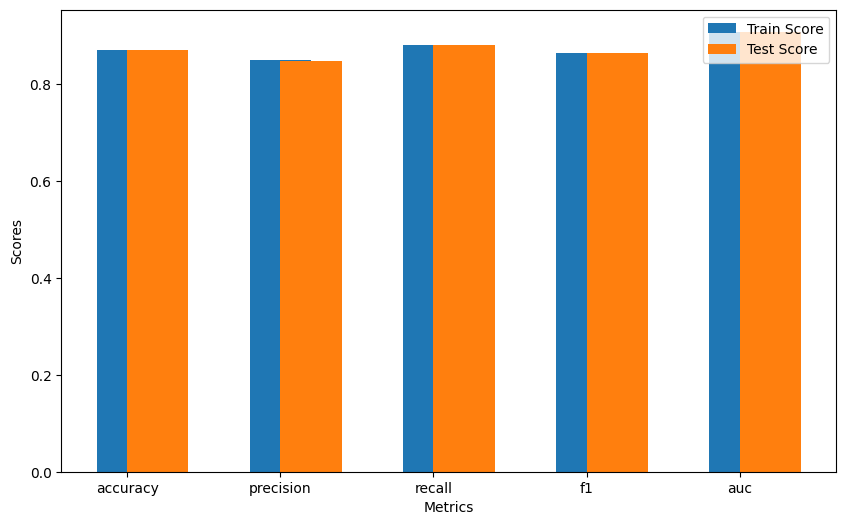

In [15]:
LR = LogisticRegression()
LR.fit(X_train_train , Y_train_train)
# cv1(X_train, Y_train, LR)
cv1(X_train_train, Y_train_train, LR)

      Metric  Mean Train Score  Mean Test Score
0   accuracy          0.892710         0.891890
1  precision          0.906201         0.904595
2     recall          0.867914         0.867386
3         f1          0.883707         0.882657
4        auc          0.923817         0.923153


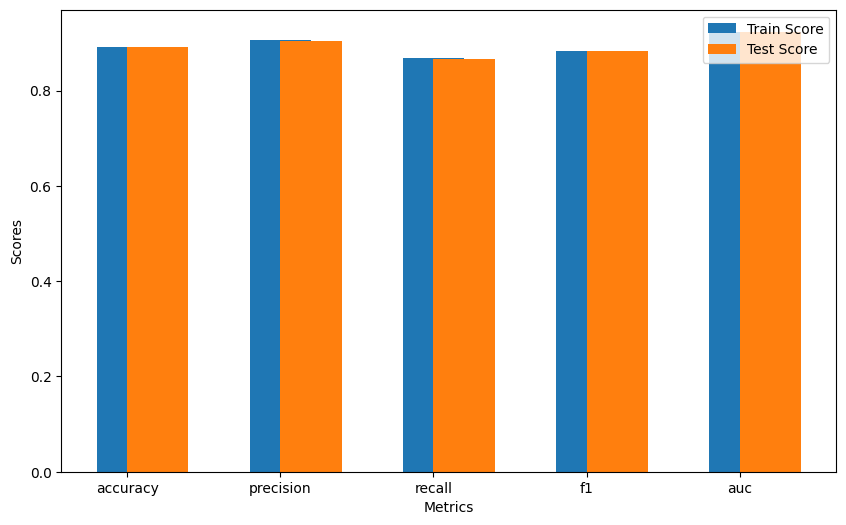

In [16]:
DT = DecisionTreeClassifier(max_features=6, max_depth=4)
DT.fit(X_train_train, Y_train_train)
cv1(X_train_train, Y_train_train, DT)

      Metric  Mean Train Score  Mean Test Score
0   accuracy          0.999952         0.998825
1  precision          0.999942         0.999361
2     recall          0.999954         0.998108
3         f1          0.999948         0.998734
4        auc          1.000000         0.999991


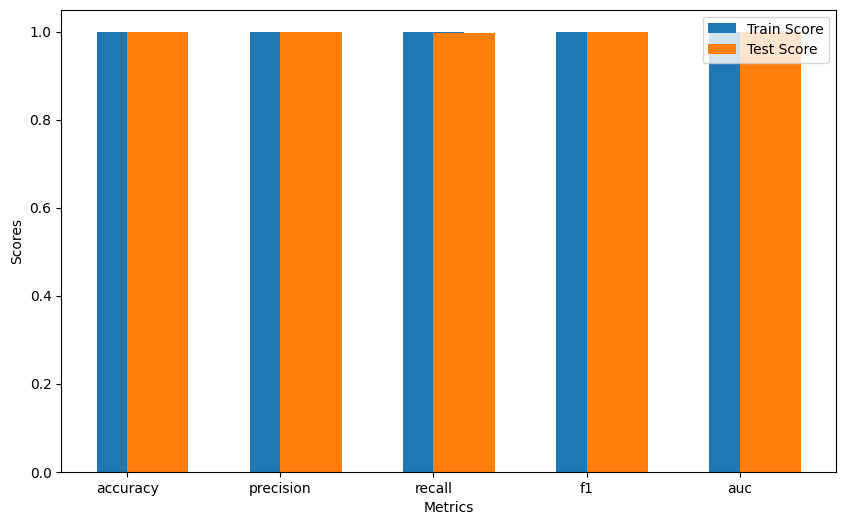

In [17]:
max_depth= [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Parameters={ 'max_depth': max_depth}
RF= RandomForestClassifier()
GridSearch(RF, Parameters, X_train_train, Y_train_train)
RF.fit(X_train_train, Y_train_train)
cv1(X_train_train, Y_train_train, RF)

      Metric  Mean Train Score  Mean Test Score
0   accuracy          0.993382         0.991522
1  precision          0.995974         0.993785
2     recall          0.989744         0.987915
3         f1          0.992850         0.990841
4        auc          0.999882         0.997970


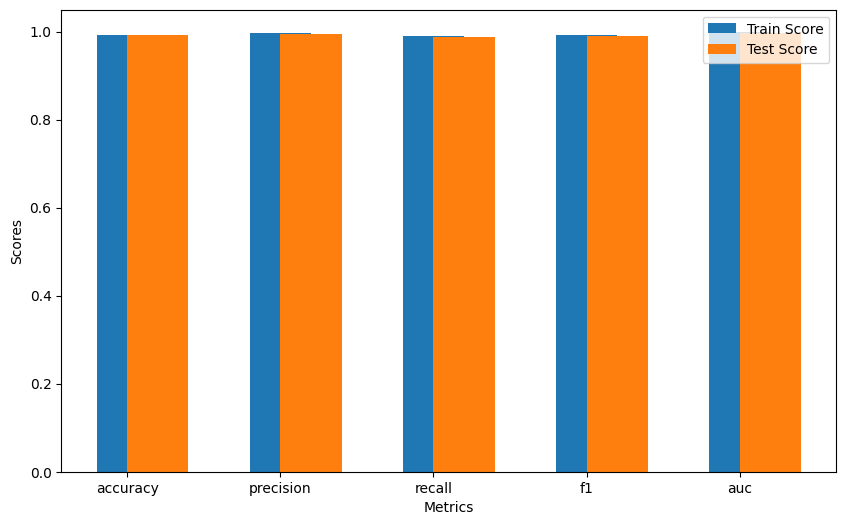

In [18]:
KNN= KNeighborsClassifier(n_neighbors=6)
KNN.fit(X_train_train, Y_train_train)
cv1(X_train_train, Y_train_train, KNN)

      Metric  Mean Train Score  Mean Test Score
0   accuracy          0.970518         0.969909
1  precision          0.971105         0.970101
2     recall          0.965388         0.965068
3         f1          0.968134         0.967479
4        auc          0.980218         0.979744


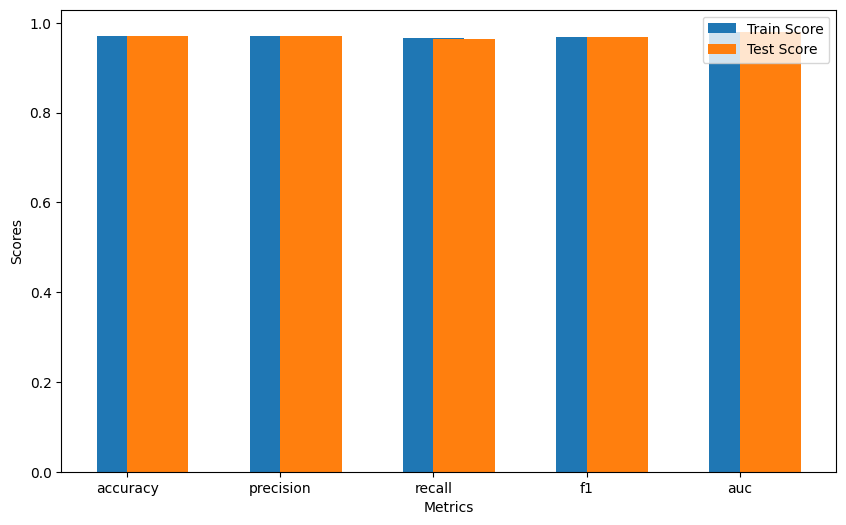

In [19]:
Linear_SVC = svm.LinearSVC(C=1)
Linear_SVC.fit(X_train_train, Y_train_train)
cv1(X_train_train, Y_train_train, Linear_SVC)